In [5]:
import pandas as pd
import numpy as np
from pcap_feature_parser import *
from pprint import pprint
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
import seaborn as sb
import glob

In [6]:
# loading the data
df = pd.read_csv('DNS_datastore.csv', index_col=0)
features = list(df.columns)[8:]

x = np.array(df.loc[:,features].fillna(0))
y = np.array(df['Label'])

sigma = (0.03 * x.mean(axis=0))

In [7]:
display(df['Source Path'].unique())
print(features)

array(['C:\\Dev\\MSc\\data\\pcaps\\benign dns.pcap',
       'C:\\Dev\\MSc\\data\\pcaps\\benign plain.pcap',
       'C:\\Dev\\MSc\\data\\pcaps\\dns2tcp tunneling.pcap',
       'C:\\Dev\\MSc\\data\\pcaps\\dnscapy tunneling.pcap',
       'C:\\Dev\\MSc\\data\\pcaps\\dnscat2_dns_tunneling_1hr.pcap',
       'C:\\Dev\\MSc\\data\\pcaps\\iodine tunneling.pcap',
       'C:\\Dev\\MSc\\data\\pcaps\\tuns_c_00000_20180330104021.pcap',
       'C:\\Dev\\MSc\\data\\pcaps\\benign packetlife_gmail.pcap',
       'C:\\Dev\\MSc\\data\\pcaps\\tuns_c_00001_20180330104040.pcap'],
      dtype=object)

['RR type', 'Subdomain Entropy', 'Payload Entropy', 'longest word Subdomain', 'Subdomain Uppercase Ratio', 'Subdomain Lowercase Ratio', 'Subdomain Numeric Ratio', 'Subdomain Special Char Ratio', 'Payload Uppercase Ratio', 'Payload Lowercase Ratio', 'Payload Numeric Ratio', 'Payload Special Char Ratio', 'Packets in Session', 'Avg Subdomain Length (Session)', 'Avg Payload Length (Session)']


## hyperparameter tuning of the RF model

#### Grid Search

#### Chosen grid

In [10]:
best_grid = {'bootstrap': True,
             'max_depth': 3,
             'max_features': 0.5,
             'min_samples_leaf': 0.1,
             'min_samples_split': 0.2,
             'n_estimators': 10,
             'n_jobs': -1,
             'verbose': 0}

rf_tuned = RandomForestClassifier()
rf_tuned.set_params(**best_grid)
rf_tuned.fit(x,y)

RandomForestClassifier(max_depth=3, max_features=0.5, min_samples_leaf=0.1,
                       min_samples_split=0.2, n_estimators=10, n_jobs=-1)

In [8]:
#from sklearn.metrics import plot_roc_curve
#plot_roc_curve(rf_tuned, x, y)

#### Comparing scores

In [32]:
def v_scores(model, x=x, y=y, sigma=sigma):
    acc = []
    F1 = []
    
    for i in range(10):
        noise = np.random.normal(0, sigma, size=x.shape)
        x = x + noise
        cv_results = cross_validate(model, x, y, 
                                    cv=StratifiedKFold(10, shuffle=True), 
                                    scoring=('accuracy', 'f1'))
        acc = acc + list(cv_results['test_accuracy'])
        F1  = F1  + list(cv_results['test_f1'])
    
    return acc, F1

In [33]:
acc_scores = pd.DataFrame()
F1_scores = pd.DataFrame()

In [13]:
%%time

# Random Forest, base model
rf_base = RandomForestClassifier()
acc_scores['RF base'], F1_scores['RF base'] = v_scores(rf_base)

Wall time: 6min 45s


In [14]:
%%time

# Random Forest, tuned model
#rf_tuned = grid_search.best_estimator_
acc_scores['RF tuned'], F1_scores['RF tuned'] = v_scores(rf_tuned)

Wall time: 35.6 s


compare against other algorithms:

In [15]:
%%time

from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
acc_scores['DT'], F1_scores['DT'] = v_scores(dt)

Wall time: 27.4 s


In [31]:
%%time

from sklearn import svm
svm = svm.SVC()
acc_scores['SVM'], F1_scores['SVM'] = v_scores(svm)

KeyboardInterrupt: 

In [17]:
%%time

from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier()
acc_scores['KNN'], F1_scores['KNN'] = v_scores(neigh)

Wall time: 1min 38s


In [20]:
#display(acc_scores)
#display(F1_scores)

,RF base,RF tuned,DT,SVM,KNN
0,0.999082,0.997245,0.999388,1.000000,0.999082
1,1.000000,0.959277,0.998163,0.870178,0.950704
2,1.000000,0.996938,0.999694,0.223515,0.996632
3,0.997857,0.996326,0.993876,0.348745,0.996020
4,1.000000,0.998469,1.000000,1.000000,0.999694
...,...,...,...,...,...
95,1.000000,0.999081,1.000000,0.999388,0.999388
96,0.998775,0.998163,0.998469,0.999081,0.999081
97,0.999694,0.995713,0.999694,0.999388,0.998163
98,1.000000,0.998163,0.999388,0.999694,0.999694


,RF base,RF tuned,DT,SVM,KNN
0,0.999413,0.998241,0.999609,1.000000,0.999413
1,1.000000,0.973256,0.998824,0.909440,0.967442
2,1.000000,0.998042,0.999804,0.013230,0.997842
3,0.998628,0.997651,0.996069,0.286481,0.997451
4,1.000000,0.999022,1.000000,1.000000,0.999804
...,...,...,...,...,...
95,1.000000,0.999413,1.000000,0.999609,0.999609
96,0.999217,0.998826,0.999021,0.999412,0.999413
97,0.999804,0.997267,0.999804,0.999609,0.998827
98,1.000000,0.998827,0.999609,0.999804,0.999804


plot accuracies and F1-scores in a bar chart:

In [29]:
acc_scores.mean(axis=0)

RF base     0.999262
RF tuned    0.997303
DT          0.998803
SVM         0.843837
KNN         0.986626
dtype: float64

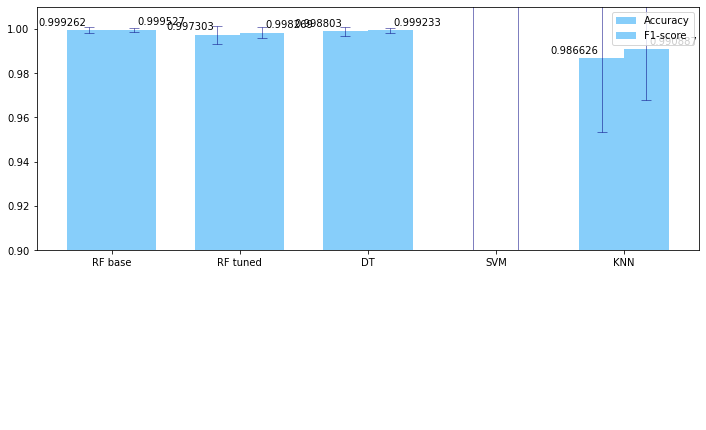

In [30]:
ind = np.arange(acc_scores.shape[1])
width = 0.35

fig, ax = plt.subplots(figsize=(10, 8))
acc_bars = ax.bar(ind-width/2, list(acc_scores.mean(axis=0)), width, yerr=list(acc_scores.std(axis=0)), label='Accuracy',
                 error_kw=dict(capsize=5, lw=0.5, capthick=0.5), color='lightskyblue', ecolor='navy')
F1_bars = ax.bar(ind+width/2, list(F1_scores.mean(axis=0)), width, yerr=list(F1_scores.std(axis=0)), label='F1-score',
                 error_kw=dict(capsize=5, lw=0.5, capthick=0.5), color='skyblue', ecolor='navy')
plt.ylim(ymin = 0.9, ymax = 1.01)
ax.set_xticks(ind)
ax.set_xticklabels(acc_scores.columns)
plt.legend()
def autolabel(labels, xpos='center'):
    ha = {'center': 'center', 'right': 'left', 'left': 'right'}
    offset = {'center': 0, 'right': 1, 'left': -1}

    for label in labels:
        height = label.get_height()
        ax.annotate('{:2f}'.format(height),
                    xy=(label.get_x() + label.get_width() / 2, height),
                    xytext=(offset[xpos]*3, 3),  # use 3 points offset
                    textcoords="offset points",  # in both dilabelions
                    ha=ha[xpos], va='bottom')


autolabel(acc_bars, "left")
autolabel(F1_bars, "right")
plt.tight_layout()
fig.savefig('Model_Metrics/Compared_Performances.png', dpi=300)